In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [134]:
import numpy as np
import pylab as plt

from astropy.stats import sigma_clip

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from parabolas import loadLeicaData
from zernikies import getZernikeCoeffsOLS, getZernikeCoeffs
from utils.utils import midPoint, stride, rolling_std, radialMask
from grid import regridXYZ, regridXYZMasked
from plotting import surface3dPlot, surfacePlot, barChartPlot
from parabolas import fitLeicaData, rotateData, newParabola

In [57]:
def zernikeOLS(x, y, z, nZern):

    # Use WLS to determine the Zernike coefficients.
    z = np.ma.masked_invalid(z)
    dz_s = stride(z.filled(np.nan), r_c=(4,4))
    dz_std = rolling_std(dz_s, no_null=False)
    dz_std_pad = np.pad(dz_std, ((2,1),(2,1)), mode='constant', constant_values=np.nan)
    dz_std_pad = np.ma.masked_where(dz_std_pad <= 20e-6, dz_std_pad)
    w = np.power(dz_std_pad, -2.)
    w = np.ma.masked_invalid(w)
    x_ = np.ma.masked_invalid(x-midPoint(x))
    y_ = np.ma.masked_invalid(y-midPoint(y))
    fl_wls = getZernikeCoeffsOLS(x_, y_, z, nZern, weights=w)
    
    return fl_wls

In [3]:
n = 512
nZern = 36
guess = [60., 0., 0., -50., 0., 0.]
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'
ref_scans = ['2020_03_16_02:21:06',
             '2020_03_16_02:54:59',
             '2020_03_16_03:19:50',
             '2020_03_16_03:44:25',
             '2020_03_16_04:09:06',
             '2020_03_16_04:33:33',
             '2020_03_16_04:58:03',
             '2020_03_16_05:22:24',
             '2020_03_16_05:47:09',
             '2020_03_16_06:11:20',
             '2020_03_16_06:35:42',
             '2020_03_16_07:00:20',
             '2020_03_16_07:24:39',
             '2020_03_16_07:48:47',
             '2020_03_16_08:12:50',
             '2020_03_16_08:37:03',
             '2020_03_16_09:01:35',
            ]

In [4]:
%%time

xMaxArr = np.zeros(len(ref_scans), dtype=np.float)
xMinArr = np.zeros(len(ref_scans), dtype=np.float)
yMaxArr = np.zeros(len(ref_scans), dtype=np.float)
yMinArr = np.zeros(len(ref_scans), dtype=np.float)

for i,rs in enumerate(ref_scans):
    
    filename = "{}/{}.ptx.csv".format(scanDir, rs)
    
    orgData, cleanData = loadLeicaData(filename, n=n, numpy=False)

    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    
    xMaxArr[i] = np.nanmax(x)
    xMinArr[i] = np.nanmin(x)
    yMaxArr[i] = np.nanmax(y)
    yMinArr[i] = np.nanmin(y)

CPU times: user 7.89 s, sys: 781 ms, total: 8.68 s
Wall time: 10.7 s


<IPython.core.display.Javascript object>


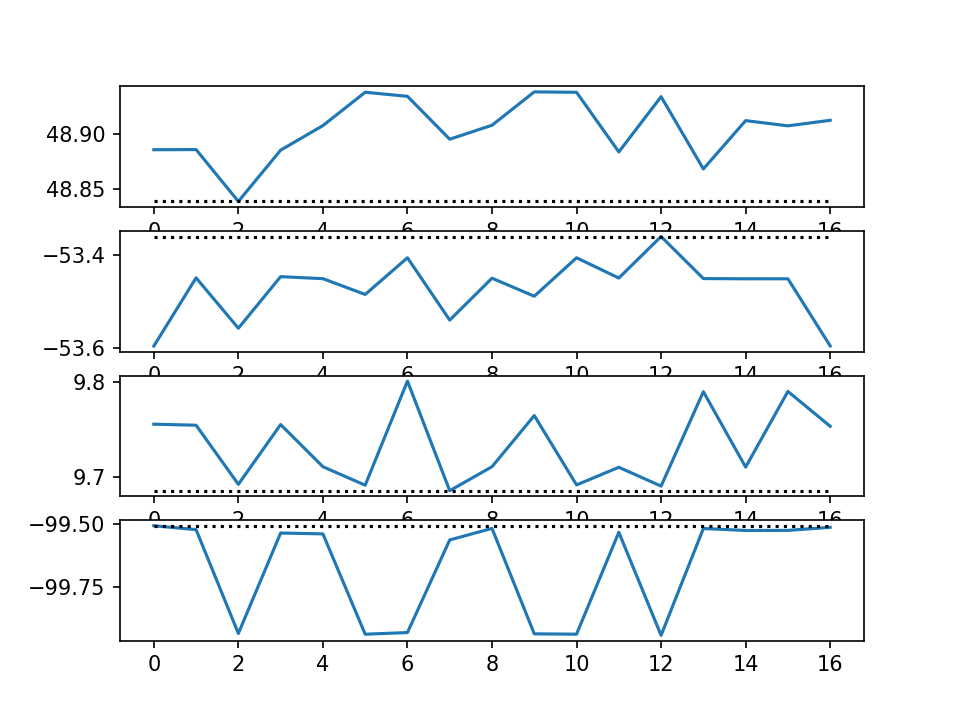

In [5]:
xMax = np.nanmin(xMaxArr)
xMin = np.nanmax(xMinArr)
yMax = np.nanmin(yMaxArr)
yMin = np.nanmax(yMinArr)

plt.figure(dpi=150)

plt.subplot(411)
plt.plot(xMaxArr)
plt.plot([xMax]*len(xMaxArr), 'k:')

plt.subplot(412)
plt.plot(xMinArr)
plt.plot([xMin]*len(xMinArr), 'k:')

plt.subplot(413)
plt.plot(yMaxArr)
plt.plot([yMax]*len(yMaxArr), 'k:')

plt.subplot(414)
plt.plot(yMinArr)
plt.plot([yMin]*len(yMinArr), 'k:')

In [10]:
%%time

refScanArr = np.zeros((len(ref_scans),3,n,n), dtype=np.float)
refScanArr = np.ma.masked_invalid(refScanArr)

for i,rs in enumerate(ref_scans):

    filename = "{}/{}.ptx.csv".format(scanDir, rs)

    orgData, cleanData = loadLeicaData(filename, n=n, numpy=False)

    x = orgData[0]
    y = orgData[1]
    z = orgData[2]

    xg, yg, zg = regridXYZ(x, y, z, n=n, xmax=xMax, xmin=xMin, ymax=yMax, ymin=yMin)

    refScanArr[i] = xg, yg, zg

CPU times: user 53.4 s, sys: 12 s, total: 1min 5s
Wall time: 45.5 s


In [11]:
avgRefScan = refScanArr.mean(axis=0)
#avgRefScan = np.ma.average(refScanArr, axis=0, weights=np.power(rmsArr, -2))
avgRefScan = np.ma.masked_invalid(avgRefScan)
#avgRefScan[2] = np.ma.masked_less(avgRefScan[2], 0)
avgRefScan[0] = np.ma.masked_where(avgRefScan[2].mask, avgRefScan[0])
avgRefScan[1] = np.ma.masked_where(avgRefScan[2].mask, avgRefScan[1])

<IPython.core.display.Javascript object>


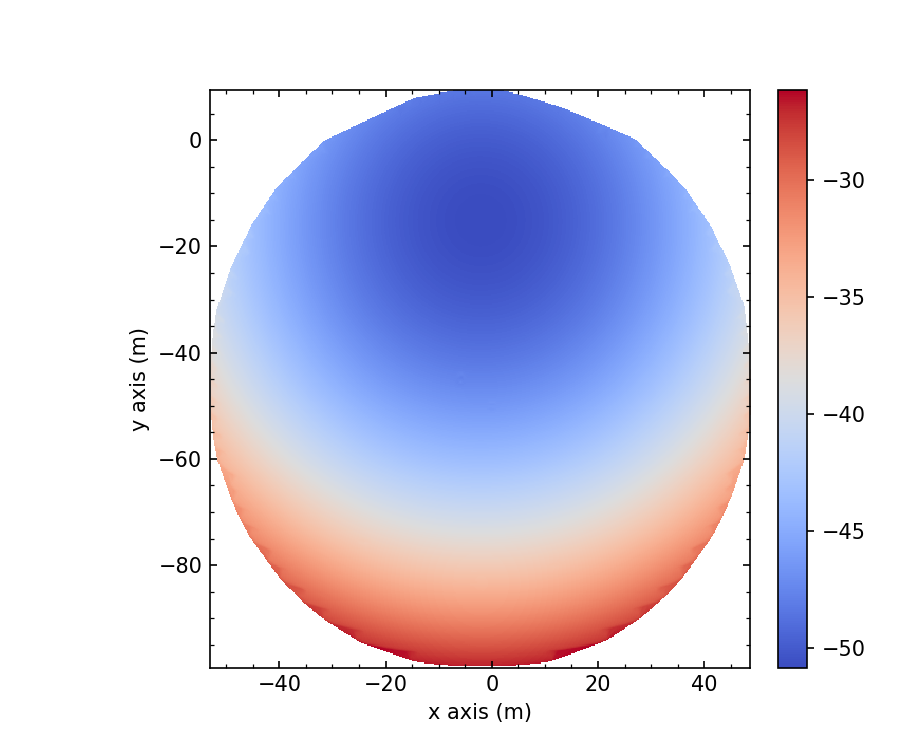

In [12]:
vmin = np.nanmin(avgRefScan[2])
vmax = np.nanmax(avgRefScan[2])
surfacePlot(avgRefScan[0], avgRefScan[1], avgRefScan[2].T, 
            vMin=vmin, vMax=vmax, midPoint=(vmin+vmax)/2)

In [145]:
refScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
orgData, cleanData = loadLeicaData(refScan, n=None, numpy=False)
xr = orgData[0]
yr = orgData[1]
zr = orgData[2]
xrg, yrg, zrg = regridXYZ(xr, yr, zr, n=n, xmax=xMax, xmin=xMin, ymax=yMax, ymin=yMin)

In [148]:
sigScanFile = "{0}/2020_03_16_02:28:31.ptx.csv".format(scanDir) #C4=-516
#sigScanFile = "{0}/2020_03_16_05:30:05.ptx.csv".format(scanDir) #C13=-520
#sigScanFile = "{0}/2020_03_16_04:16:39.ptx.csv".format(scanDir) #C7=-523
#sigScanFile = "{0}/2020_03_16_07:56:13.ptx.csv".format(scanDir) #C7=-532
#sigScanFile = "{0}/2020_03_16_09:09:14.ptx.csv".format(scanDir) #C13=-520
sigScanFile = "{0}/2020_03_16_06:43:17.ptx.csv".format(scanDir) # C4=-560
iz = 4
izv = -560
orgData, cleanData = loadLeicaData(sigScanFile, n=n, numpy=False)
x = orgData[0]
y = orgData[1]
z = orgData[2]
xg, yg, zg = regridXYZ(x, y, z, n=n, xmax=xMax, xmin=xMin, ymax=yMax, ymin=yMin)

In [149]:
diff = zg - avgRefScan[2]
diff = zg - zrg
diff = sigma_clip(diff)

<IPython.core.display.Javascript object>


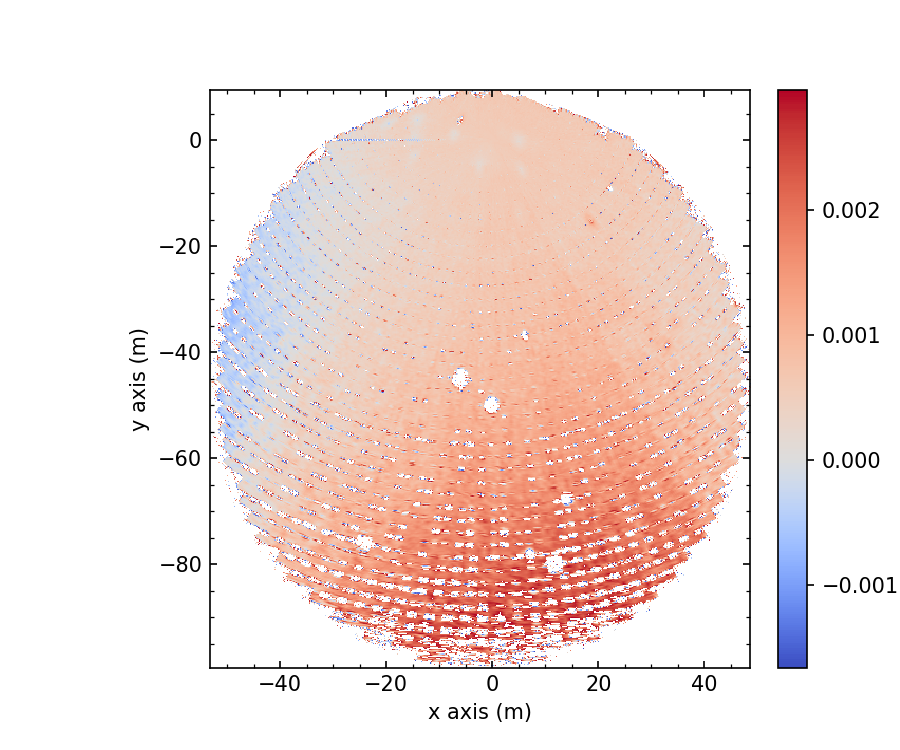

722.0615657605515 -1662.8319931015767 2965.0137355829997


In [150]:
surfacePlot(xg, yg, diff.T, vMin=diff.min(), vMax=diff.max())
print(diff.std()*1e6, diff.min()*1e6, diff.max()*1e6)

In [151]:
fl = getZernikeCoeffs(diff.filled(0)[::-1].T, nZern, norm='active-surface')
fl = np.asarray(fl)
diff_ = np.ma.copy(diff)
diff_[~radialMask(xg, yg, 45.7)] = np.nan
fl_wls = zernikeOLS(xg, yg, diff_, nZern)

/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/home/scratch/psalas/LASSI/lassi-analysis_v2/psalas_lassi_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


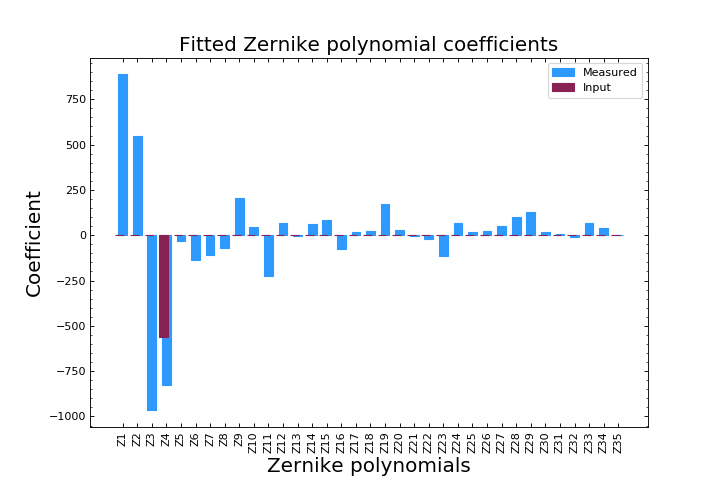

<IPython.core.display.Javascript object>


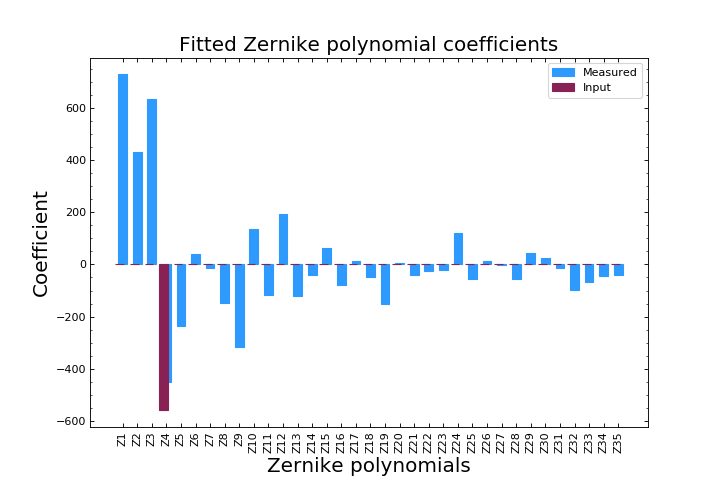

-560 -825.9217628687875 -451.52544143968703 -638.7236021542373
-578.8183850320038


In [152]:
expected = np.zeros(37)
expected[iz] = izv
barChartPlot(np.arange(1,36), fl_wls[1:36]*1e6, expected=expected[1:36])
barChartPlot(np.arange(1,36), fl[1:36]*1e6, expected=expected[1:36])
print(izv, (fl_wls*1e6)[iz], (fl)[iz]*1e6, ((fl_wls*1e6)[iz]+(fl)[iz]*1e6)*0.5)
print(((fl_wls/fl_wls[4:].std()**2 + fl/fl[4:].std()**2)/(1./fl_wls[4:].std()**2 + 1./fl[4:].std()**2))[iz]*1e6)